In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pwlf
import pathlib
import math
import numpy as np

In [3]:
src = pathlib.Path().cwd().parent.parent / 'data' / 'processed'

In [25]:
no_death = pd.read_csv(src / 'no-death-from-treatment-data' / 'no-death.csv', index_col=0)


In [26]:
no_death.index = pd.to_datetime(no_death.index)

In [27]:
no_death.index

DatetimeIndex(['2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06',
               '2021-08-07', '2021-08-08', '2021-08-09', '2021-08-10',
               '2021-08-11', '2021-08-12', '2021-08-13', '2021-08-14',
               '2021-08-15', '2021-08-16', '2021-08-17', '2021-08-18',
               '2021-08-19', '2021-08-20', '2021-08-21', '2021-08-22',
               '2021-08-23', '2021-08-24', '2021-08-25', '2021-08-26',
               '2021-08-27', '2021-08-28', '2021-08-29', '2021-08-30',
               '2021-08-31', '2021-09-01', '2021-09-02', '2021-09-03',
               '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07',
               '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11',
               '2021-09-12', '2021-09-13', '2021-09-14', '2021-09-15',
               '2021-09-16', '2021-09-17', '2021-09-18', '2021-09-19',
               '2021-09-20'],
              dtype='datetime64[ns]', name='date_report', freq=None)

In [23]:
# shift left
# no_case['no_case_rollmean7d_sl'] = no_case.no_case_rollmean7d.shift(-10)
# no_case['no_case_sl'] = no_case.no_case.shift(-10)
# no_case = no_case.loc[:'2021-09-01',]

In [9]:
# no_case.tail(15)
# no_case_by_adh

In [25]:
# Plot no_case
# fig, ax = plt.subplots(figsize=(20, 8))
# ax.plot(no_case.index, no_case.no_case, linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [26]:
# Plot log no_case
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot(no_case.index, (no_case.no_case_rollmean7d).transform(math.log), linewidth=3, color='red', alpha=0.6)
# ax.set_ylabel('Số ca mới')
# # ax.set_ylim([0, 7500])
# ax.set_xlabel('Ngày')
# ax.set_xticks(no_case.index)
# ax.tick_params(axis='x', labelrotation=90)

In [31]:
# Model config
beta_dict = {}
slope_dict = {}
x_dict = {}
y_dict = {}
x_hat_dict = {}
y_hat_dict = {}
predicted_var_dict = {}
ub_dict = {}
lb_dict = {}
xlabels_dict = {}
plot_title_dict = {}
no_death_col = 'no_death_rollmean7d'
forecast_horizon = 20
policy_change = [no_death.index.min(),
#                  '2021-05-31', # chi thi 15, 16
#                  '2021-06-14', # chi thi 15
#                  '2021-06-19', # chi thi 10
#                  '2021-07-09', # chi thi 16
#                  '2021-07-19', # chi thi 16
#                  '2021-07-27', # ngung xn hang loat
#                  '2021-08-01', # chi thi 16
                 '2021-08-10', # quan huyen k fit
                 '2021-08-15',
                 '2021-08-23', # phong toa
                 no_death.index.max()
                ]

In [29]:
# no_death.index - no_death.index.min()

TimedeltaIndex([ '0 days',  '1 days',  '2 days',  '3 days',  '4 days',
                 '5 days',  '6 days',  '7 days',  '8 days',  '9 days',
                '10 days', '11 days', '12 days', '13 days', '14 days',
                '15 days', '16 days', '17 days', '18 days', '19 days',
                '20 days', '21 days', '22 days', '23 days', '24 days',
                '25 days', '26 days', '27 days', '28 days', '29 days',
                '30 days', '31 days', '32 days', '33 days', '34 days',
                '35 days', '36 days', '37 days', '38 days', '39 days',
                '40 days', '41 days', '42 days', '43 days', '44 days',
                '45 days', '46 days', '47 days', '48 days'],
               dtype='timedelta64[ns]', name='date_report', freq=None)

In [32]:
# Forecast no_death
# forecast_horizon = 15
# policy_change = [no_death.index.min(), '2021-05-31', '2021-06-14', '2021-06-19', 
#                  '2021-07-09', '2021-07-19', '2021-08-01', no_death.index.max()]

x = (no_death.index - no_death.index.min()) / pd.Timedelta(1, unit='d')
y = no_death[no_death_col].replace(0, np.nan).transform(math.log).fillna(0)
x0 = (pd.to_datetime(policy_change) - no_death.index.min()) / pd.Timedelta(1, unit='d')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon-1)
).strftime('%d-%m')

model = pwlf.PiecewiseLinFit(x, y)
model.fit_with_breaks(x0)

x_hat = np.arange(min(x), max(x) + forecast_horizon)
y_hat = model.predict(x_hat)

predicted_var = model.prediction_variance(x_hat)
ub = y_hat + 1.96*np.sqrt(predicted_var)
lb = y_hat - 1.96*np.sqrt(predicted_var)

# Add result to dict
beta_dict['tphcm'] = list(model.beta)
slope_dict['tphcm'] = list(model.calc_slopes())
x_dict['tphcm'] = list(x)
y_dict['tphcm'] = list(y)
x_hat_dict['tphcm'] = list(x_hat)
y_hat_dict['tphcm'] = list(y_hat)
predicted_var_dict['tphcm'] = list(predicted_var)
ub_dict['tphcm'] = list(ub)
lb_dict['tphcm'] = list(lb)
xlabels_dict['tphcm'] = list(xlabels)
plot_title_dict['tphcm'] = 'TP HCM'

In [33]:
# dir(model)
# slope_dict
model.r_squared()

0.8717678973708269

In [30]:
# beta_dict['tphcm']

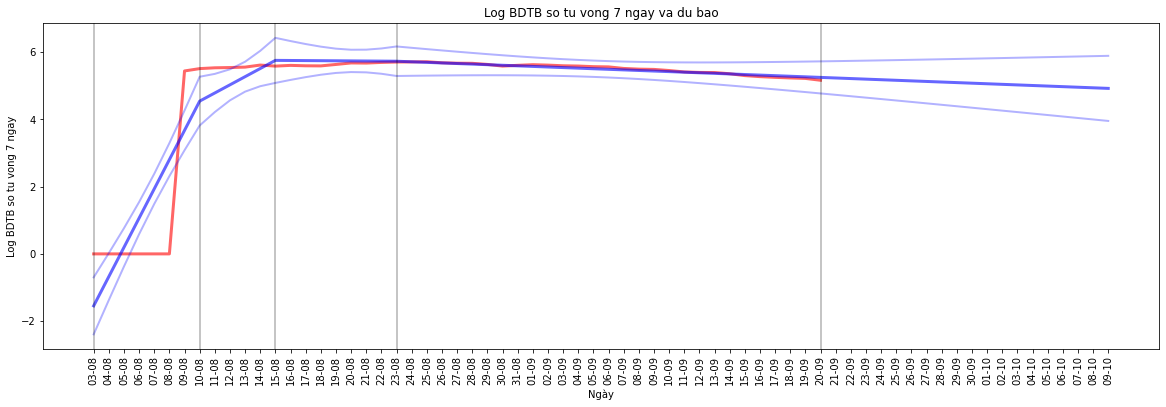

In [34]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, y, linewidth=3, color='red', alpha=0.6)
ax.plot(x_hat, y_hat, linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat, ub, linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat, lb, linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel('Log BDTB so tu vong 7 ngay')
ax.set_xlabel('Ngày')
ax.set_title('Log BDTB so tu vong 7 ngay va du bao')
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)

xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon - 1)
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)

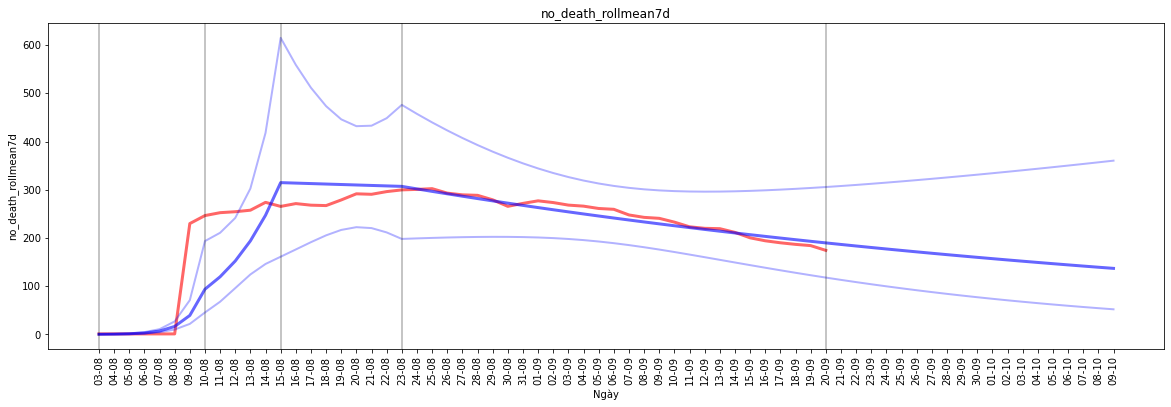

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(x, np.exp(y), linewidth=3, color='red', alpha=0.6)
# ax.plot(x, no_death.no_death_sl, linewidth=3, color='orange', alpha=0.5)
ax.plot(x_hat,  np.exp(y_hat), linewidth=3, color='blue', alpha=0.6)
ax.plot(x_hat,  np.exp(ub), linewidth=2, color='blue', alpha=0.3)
ax.plot(x_hat,  np.exp(lb), linewidth=2, color='blue', alpha=0.3)
ax.set_ylabel(no_death_col)
ax.set_title(no_death_col)
for i in x0:
    ax.axvline(i, color='black', alpha=0.3)
ax.set_xlabel('Ngày')
xlabels = pd.date_range(
    no_death.index.min(),
    no_death.index.max() + pd.Timedelta(days=forecast_horizon -1 )
).strftime('%d-%m')
ax.set_xticks(x_hat)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', labelrotation=90)
# ax.set_ylim([0, 10000])

In [36]:
slope = pd.DataFrame(slope_dict).transpose()
slope.columns = pd.to_datetime(policy_change).strftime('%d-%m-%Y')[:-1]
r0 = np.exp(slope)

# slope.to_csv(src / 'predicted-no-death-from-treatment-data' / 'slope.csv')
# r0.to_csv(src / 'predicted-no-death-from-treatment-data' / 'r0.csv')
# slope
r0

,03-08-2021,10-08-2021,15-08-2021,23-08-2021
tphcm,2.385296,1.274058,0.996877,0.982968
